<a href="https://colab.research.google.com/github/pachterlab/CGP_2024_2/blob/main/condition_kinetics_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this notebook we will fit the bursty model of transcription, with length-biased technical noise, to drug-resistant lung cancer cells. We will investigate the changes in kinetics between cells pre- and post-resistance acquisition, i.e., the perturbation-specific kinetics induced by drug treatment and resistance development.**

## **Read in data and metadata**

In [ ]:
#Install
!pip install --quiet monod
!pip install -U --quiet loompy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 29.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.4 MB/s eta 0:00:00


In [ ]:
#gene length annotation
!wget --content-disposition https://github.com/pachterlab/CGP_2024_2/raw/main/reference/gg_200525_genome_polyA_cum_3

#loom files
!wget --content-disposition https://data.caltech.edu/records/z3qv2-15815/files/example_looms.tar.gz?download=1
!tar -xvf example_looms.tar.gz

--2024-07-06 15:39:37--  https://github.com/pachterlab/CGP_2024_2/raw/main/reference/gg_200525_genome_polyA_cum_3
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pachterlab/CGP_2024_2/main/reference/gg_200525_genome_polyA_cum_3 [following]
--2024-07-06 15:39:37--  https://raw.githubusercontent.com/pachterlab/CGP_2024_2/main/reference/gg_200525_genome_polyA_cum_3
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9325163 (8.9M) [text/plain]
Saving to: ‘gg_200525_genome_polyA_cum_3’

gg_200525_genome_po 100%[===================>]   8.89M  --.-KB/s    in 0.1s    

2024-07-06 15:39:38 (79.5 MB/s) - ‘gg

In [ ]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

/usr/local/lib/python3.10/dist-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/usr/local/lib/python3.10/dist-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/usr/local/lib/python3.10/dist-packages/loompy/bus_file.py:1

In [ ]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import scipy.stats

import random
import glob
import os

Data is downloaded from https://www.nature.com/articles/s41467-021-21884-z

## **Run *Monod* inference on loom files**

In [ ]:
#Set up the filepaths and metadata for Monod run
loom_filepaths = ['./all_cancer_ctrl_sub.loom','./all_cancer_dt_sub.loom']

dataset_names = ['Day0','Day3']

transcriptome_filepath = './gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


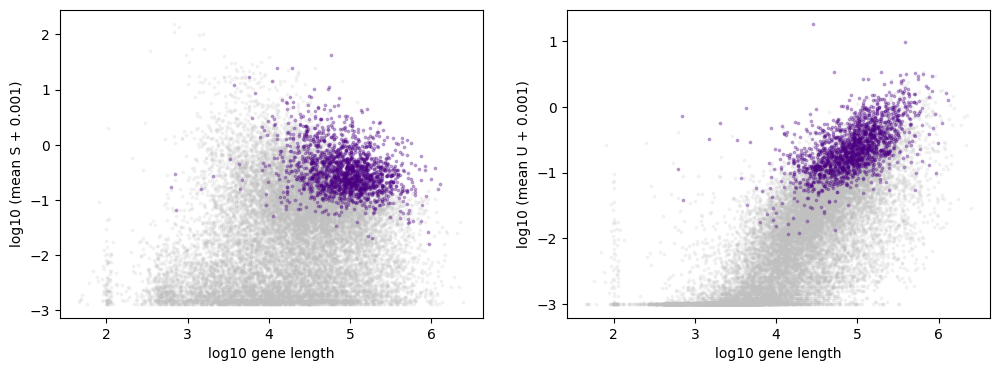

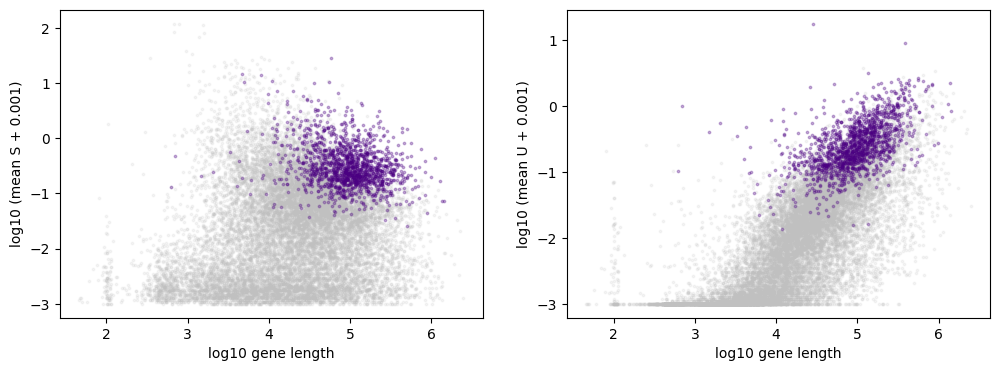

In [ ]:
#Select 500 genes to fit both Day 0 (pre-resistance) and Day 3 (drug-tolerant) cells on
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./',meta='DT_Days',batch_id=1,\
                                             n_genes=500,exp_filter_threshold=None,cf=None)

In [ ]:
# OR if you want to specify the genes to fit

# example_genes = []
# dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
#                                              transcriptome_filepath, \
#                                              dataset_names, \
#                                              attribute_names=attribute_names,\
#                                              batch_location='./',meta='DT_Days',batch_id=1,\
#                                              n_genes=500,exp_filter_threshold=None,
#                                              genes_to_fit=example_genes)

**Run *Monod* Inference**

In [ ]:
#Define bounds for parameters
phys_lb = [-2.0, -1.8, -1.8 ] #lower bounds for b,beta,gamma (log10)
phys_ub = [4.2, 2.5, 2.5] #upper bounds for b,beta,gamma
samp_lb = [-9, -4] #lower bounds for sampling parameters (c_u,lambda_s)
samp_ub = [-4, 1.5] #upper bounds for sampling parameters (c_u,lambda_s)
# gridsize = [5,6]
gridsize = [5,6] #run across grid of technical/sampling parameters

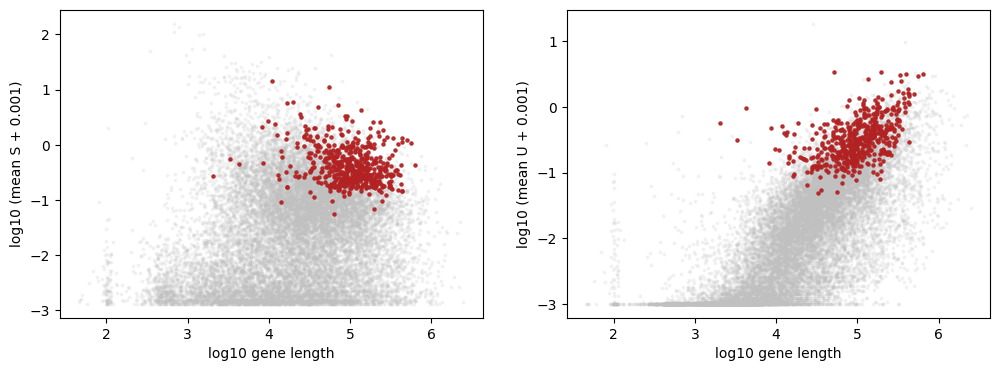

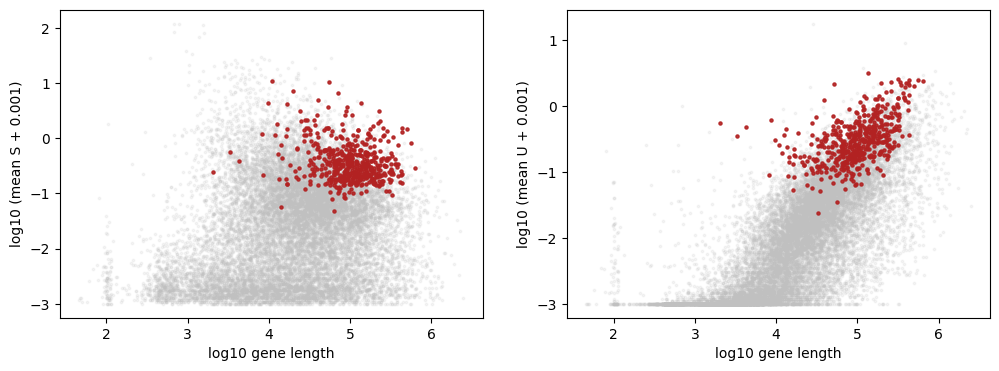

In [ ]:

for i in range(len(dataset_strings)):
  #Set burst model with poisson technical sampling
  fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

  #Set up inference
  inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
              dataset_strings[i],fitmodel,use_lengths = True,
              gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})

  search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
              dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=None)

  #Run inference
  full_result_string = inference_parameters.fit_all_grid_points(1,search_data) #only use one core on Colab


In [ ]:
result_strings = [i+'/Bursty_Poisson_5x6/grid_scan_results.res' for i in dataset_strings] #Get results
print(result_strings)

['./gg_240704_029_DT_Days_1/Day0/Bursty_Poisson_5x6/grid_scan_results.res', './gg_240704_029_DT_Days_1/Day3/Bursty_Poisson_5x6/grid_scan_results.res']


## **DE-$\theta$ analysis of results**

Read in results and perform rejection statistics

In [ ]:
sr_arr = []
sd_arr = []
for r in range(len(result_strings)):
  sr = monod.analysis.load_search_results(result_strings[r])
  sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[r]+'/raw.sd')

  sr.find_sampling_optimum() #Get optimal technical sampling param from grid

  #Chi sq rejection
  _=sr.chisquare_testing(sd,threshold=1e-3)
  sr.chisq_best_param_correction(sd,Ntries=4,viz=False,threshold=1e-3)

  sr.compute_sigma(sd,num_cores=1) #Compute std error for parameters

  monod.analysis.make_batch_analysis_dir([sr],dir_string)
  sr.update_on_disk()

  sr_arr += [sr]
  sd_arr += [sd]


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
#Function to find DE-theta genes between two Monod results objects

def make_fcs_srs(sr1,sr2,sd1,sd2,gene_names,gf_rej=False,thrpars=2,thrmean=1,outlier_de=True,nuc=False,correct_off=False):
    '''
    Utilize different metrics to find fold-changes (FCs) between clusters in different SRs

    sr1: SearchResults object 1 (single object)
    sr2: SearchResults object 2
    sd1: SearchData object for sr1
    sd2: SearchData object for sr2
    gene_names: list of gene names to compare between SRs
    gf_rej: whether to use boolean list of rejected genes from both SRs
    thrpars: FC threshold value (to call DE-theta genes)
    thrmean: Mean S expression threshold value, for genes to consider
    outlier_de: Use iterative outlier calling procedure to assign DE-theta genes (see Monod https://github.com/pachterlab/monod_examples/blob/main/Monod_demo.ipynb)
    nuc: is this nuclear RNA data
    correct_off: boolean to correct parameter offset with ODR
    '''

    all_filt_fcs = pd.DataFrame()
    fcs,types,which_pair,highFC,spliceFC,g_names,out_de = ([] for i in range(7))

    sr1 = sr1
    sr2 = sr2

    gfilt1 = [list(sr1.gene_names).index(i) for i in gene_names]
    gfilt2 = [list(sr2.gene_names).index(i) for i in gene_names]

    par_vals1 = np.copy(sr1.param_estimates[:,gfilt1,:])
    par_vals2 = np.copy(sr2.param_estimates[:,gfilt2,:])

    parnames = ('b','beta','gamma')

    if correct_off:
        param_names = sr1.model.get_log_name_str()
        offsets = []
        for k in range(len(param_names)):
            m1 = par_vals1[0,:,k]
            m2 = par_vals2[0,:,k]
            offset = analysis.diffexp_fpi(m1,m2,param_names[k],viz=False)[1]
            par_vals2[0,:,k] -= offset

        fc_par = (par_vals1-par_vals2)/np.log10(2)
    else:
        fc_par = (par_vals1-par_vals2)/np.log10(2)  #Get FCs between cluster params

    print('fc_par.shape: ',fc_par.shape)
    if nuc:
        fc_s_par = np.log2(sd1.layers[0][gfilt1,:].mean(1)/sd2.layers[0][gfilt2,:].mean(1)) #Get unspliced FCs
    else:
        fc_s_par = np.log2(sd1.layers[1][gfilt1,:].mean(1)/sd2.layers[1][gfilt2,:].mean(1)) #Get spliced FCs

    print('fc_s_par.shape: ',fc_s_par.shape)

    #Use outlier calling method to find DE genes
    if outlier_de:
        if len(sr1.gene_names) != len(sr2.gene_names):
            print('Not running outlier DE. SRs need to have the same gene dimensions.')
            par_bool_de = np.zeros((len(gene_names),len(parnames)))
        else:
            dr_analysis = monod.analysis.diffexp_pars(sr1,sr2,viz=True,modeltype='id',use_sigma=True)
            par_bool_de = dr_analysis[1].T



  #-----is parameter FC significant -----
    if gf_rej is False:
        gf_rej = [True]*(len(gfilt1))
    else:
        gf_rej = ~(sr1.rejected_genes[gfilt1]) & ~(sr2.rejected_genes[gfilt2])


    for n in range(len(parnames)):
        #Boolean for if large param FC and not rejected gene (with minimum expression)
        if nuc:
            gf_highnoise = (np.abs(fc_par[0,:,n])>thrpars)  \
                & ((sd1.layers[0][gfilt1,:].mean(1)>thrmean) | (sd2.layers[0][gfilt2,:].mean(1)>thrmean)) \
                & gf_rej
        else:
            gf_highnoise = (np.abs(fc_par[0,:,n])>thrpars)  \
                & ((sd1.layers[1][gfilt1,:].mean(1)>thrmean) | (sd2.layers[1][gfilt2,:].mean(1)>thrmean)) \
                & gf_rej

        #Boolean for FC (above) but no FC detected at S-level
        gf_highnoise_meanS = gf_highnoise & (np.abs(fc_s_par)<1) & gf_rej

        #Boolean for FC (above)
        gf_onlyhigh = gf_highnoise & gf_rej

        #For dataframe
        fcs += list(fc_par[0,gf_rej,n])
        g_names += list(gene_names[gf_rej])
        which_pair += [[1,2]]*np.sum(gf_rej)
        highFC += list(gf_onlyhigh[gf_rej])
        spliceFC += list(gf_highnoise_meanS[gf_rej])
        types += [parnames[n]]*np.sum(gf_rej)
        if outlier_de:
            out_de += list(par_bool_de[gf_rej,n])

    if outlier_de:
        all_filt_fcs['deTheta_outlier'] = out_de

    all_filt_fcs['log2FC'] = fcs
    all_filt_fcs['gene'] = g_names
    all_filt_fcs['cluster_pair'] = which_pair
    all_filt_fcs['deTheta_FC'] = highFC
    all_filt_fcs['deTheta_noDeMuS'] = spliceFC
    all_filt_fcs['param'] = types

    return all_filt_fcs


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Get params for each gene, which cluster it marks, and whether it's DE in any param
def get_gene_DE(all_filt_fcs):
    bs = all_filt_fcs[all_filt_fcs.param.isin(['b'])].log2FC
    betas = all_filt_fcs[all_filt_fcs.param.isin(['beta'])].log2FC
    gammas = all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].log2FC
    highFCs = np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].deTheta_FC)
    noSpliceFCs = np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].deTheta_noDeMuS) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].deTheta_noDeMuS) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].deTheta_noDeMuS)

    names = all_filt_fcs[all_filt_fcs.param.isin(['b'])].gene

    dom = []
    for i in range(len(noSpliceFCs)):
        fc_b = list(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].log2FC)[0]
        fc_beta = list(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].iloc[[i]].log2FC)[0]
        fc_gamma = list(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].iloc[[i]].log2FC)[0]

        sig_b = list(np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].deTheta_noDeMuS))[0]
        sig_beta = list(np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].iloc[[i]].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].iloc[[i]].deTheta_noDeMuS))[0]

        sig_gamma = list(np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].iloc[[i]].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].iloc[[i]].deTheta_noDeMuS))[0]


        pairs = list(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].cluster_pair)[0]

# ----- Cell type 'marker' means increase in burst freq,burst,or splicing, or decrease in deg (increased 'stability') ----

        #Increase in burst freq (not outweighted by burst size)
        if (-1*fc_beta > 0 and sig_beta and -1*fc_gamma > 0 and sig_gamma) :
            if (np.abs(fc_b) < np.abs(fc_beta)):
                dom += [pairs[0]]
            elif (fc_b > 0 and sig_b):
                dom += [pairs[0]]
            elif (fc_b < 0 and sig_b):
                dom += [pairs[1]]
            else:
                dom += ['None']
        elif (fc_beta > 0 and sig_beta and fc_gamma > 0 and sig_gamma) :
            if (np.abs(fc_b) < np.abs(fc_beta)):
                dom += [pairs[1]]
            elif (fc_b > 0 and sig_b):
                dom += ['None'] #don't know
            elif (fc_b < 0 and sig_b):
                dom += [pairs[1]]
            else:
                dom += ['None']
        elif sig_b:
            if np.abs(fc_b) > np.abs(fc_beta) and np.abs(fc_b) > np.abs(fc_gamma):
                if fc_b > 0:
                    dom += [pairs[0]]
                else:
                    dom += [pairs[1]]
            elif np.abs(fc_b) < np.abs(fc_beta):
                if fc_beta > 0:
                    dom += [pairs[0]]
                elif fc_beta < 0:
                    dom += [pairs[1]]
            elif np.abs(fc_b) < np.abs(fc_gamma):
                if fc_gamma < 0:
                    dom += [pairs[0]]
                elif fc_gamma > 0:
                    dom += [pairs[1]]
            else:
                dom += ['None']
        elif (fc_beta > 0 and sig_beta):
            dom += [pairs[0]]
        elif (fc_gamma > 0 and sig_gamma): #individual FCs
            dom += [pairs[1]]
        elif  (fc_beta < 0 and sig_beta):
            dom += [pairs[1]]
        elif (fc_gamma < 0 and sig_gamma):
            dom += [pairs[0]]
        else:
            dom += ['None']


    return bs,-1*betas,-1*gammas,dom,highFCs,noSpliceFCs,names #-1 for plotting purposes

In [ ]:
#Plot FCs of parameters between two clusters

def plot_de(outs,names_plot,assign_colors,mark_plot=[],xpos=[],ypos=[],arrow=[],figsize=(10,4),betag=False,xlims=[-10,10],fname=None):
    fig,ax = plt.subplots(1,2,figsize=figsize)

    name_inds = [list(outs[6]).index(i) for i in names_plot]

    labs = np.array(outs[3])
    g=sns.scatterplot(x=list(outs[0][labs =='None']),y=list(outs[1][labs=='None']),
                      hue=list(pd.Categorical(outs[3])[labs=='None']),
                      palette=assign_colors,ax=ax[0],style=list(outs[5][labs=='None']),alpha=0.1,s=100,edgecolor='black')

    sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==False)]),
                    y=list(outs[1][(labs!='None') &  (outs[5]==False)]),
                    hue=list(pd.Categorical(outs[3])[(labs!='None') &  (outs[5]==False)]),
                      palette=assign_colors,ax=ax[0],marker='o',alpha=0.6,s=100,edgecolor='black')

    sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==True)]),
                    y=list(outs[1][(labs!='None')  &  (outs[5]==True)]),
                    hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==True)]),
                      palette=assign_colors,ax=ax[0],marker='X',alpha=0.8,s=120,edgecolor='black')

    #Annotate genes
    for n in range(len(names_plot)):
        x=list(outs[0])[name_inds[n]]
        y=list(outs[1])[name_inds[n]]
        h=[pd.Categorical(outs[3])[name_inds[n]]]
        if_x=list(outs[5])[name_inds[n]]

        if if_x:
            shape = 'X'
        else:
            shape = 'o'

        if arrow[n]:
            #Replot, so annotated points show up on top
            sns.scatterplot(x=x,
                    y=y,
                    hue=h,
                      palette=assign_colors,ax=ax[0],marker=shape,alpha=0.8,s=120,edgecolor='black',
                           legend=False)

            ax[0].annotate(names_plot[n], (x, y), fontsize=14,
                           xytext=(x+xpos[n],y+ypos[n]),weight="bold", color=assign_colors[mark_plot[n]],
                       arrowprops = dict(facecolor=assign_colors[mark_plot[n]],
                                         arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",lw=0.4))
        else:
            #Replot, so annotated points show up on top
            sns.scatterplot(x=x,
                    y=y,
                    hue=h,
                      palette=assign_colors,ax=ax[0],marker=shape,alpha=0.8,s=120,edgecolor='black',
                           legend=False)

            ax[0].annotate(names_plot[n], (x, y),fontsize=14,
                           xytext=(x+xpos[n], y+ypos[n]),color=assign_colors[mark_plot[n]],weight="bold")

    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

    xl =np.asarray([xlims[0],xlims[1]])
    xlx = [xl[0],xl[1]]
    xly = [xl[0],xl[1]]
    ax[0].set_xlim(xlx)
    ax[0].set_ylim(xly)

    ax[0].plot(xl,-xl,'--',linewidth=2.5,c='crimson',alpha=0.3)

    ax[0].set_xlabel(r'$\log_{2}$FC $b$ ',fontsize=14)
    ax[0].set_ylabel(r'$-\log_{2}$FC $\beta$ ',fontsize=14)

    ax[0].tick_params(axis='both', which='major', labelsize=14,)




    if betag == False:
        labs = np.array(outs[3])
        g=sns.scatterplot(x=list(outs[0][labs =='None']),y=list(outs[2][labs=='None']),
                          hue=list(pd.Categorical(outs[3])[labs=='None']),
                          palette=assign_colors,ax=ax[1],style=list(outs[5][labs=='None']),alpha=0.1,s=100,edgecolor='black')

        sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==False)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==False)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==False)]),
                          palette=assign_colors,ax=ax[1],marker='o',alpha=0.6
                        ,s=100,edgecolor='black')


        sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==True)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==True)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==True)]),
                          palette=assign_colors,ax=ax[1],marker='X',
                        alpha=0.8,s=120,edgecolor='black')
        #Annotate genes
        for n in range(len(names_plot)):
            x=list(outs[0])[name_inds[n]]
            y=list(outs[2])[name_inds[n]]
            h=[pd.Categorical(outs[3])[name_inds[n]]]
            if_x=list(outs[5])[name_inds[n]]

            if if_x:
                shape = 'X'
            else:
                shape = 'o'

            if arrow[n]:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=100,edgecolor='black',
                               legend=False)

                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),weight="bold", color=assign_colors[mark_plot[n]],
                           arrowprops = dict(facecolor=assign_colors[mark_plot[n]],
                                             arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",
                                             lw=0.4,))
            else:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=120,edgecolor='black',
                               legend=False)

                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),color=assign_colors[mark_plot[n]],weight="bold")


        sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

        xl =np.asarray([xlims[0],xlims[1]])
        xlx = [xl[0],xl[1]]
        xly = [xl[0],xl[1]]
        ax[1].set_xlim(xlx)
        ax[1].set_ylim(xly)

        ax[1].plot(xl,-xl,'--',linewidth=2.5,c='crimson',alpha=0.3)

        ax[1].set_xlabel(r'$\log_{2}$FC $b$ ',fontsize=14)
        ax[1].set_ylabel(r'$-\log_{2}$FC $\gamma$ ',fontsize=14)

        ax[1].tick_params(axis='both', which='major', labelsize=14,)
    else:
        labs = np.array(outs[3])
        g=sns.scatterplot(x=list(outs[1][labs =='None']),y=list(outs[2][labs=='None']),
                          hue=list(pd.Categorical(outs[3])[labs=='None']),
                          palette=assign_colors,ax=ax[1],style=list(outs[5][labs=='None']),alpha=0.1,s=100,edgecolor='black')

        sns.scatterplot(x=list(outs[1][(labs!='None')  &  (outs[5]==False)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==False)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==False)]),
                          palette=assign_colors,ax=ax[1],marker='o',alpha=0.6
                        ,s=100,edgecolor='black')


        sns.scatterplot(x=list(outs[1][(labs!='None')  &  (outs[5]==True)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==True)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==True)]),
                          palette=assign_colors,ax=ax[1],marker='X',
                        alpha=0.8,s=120,edgecolor='black')
        #Annotate genes
        for n in range(len(names_plot)):
            x=list(outs[1])[name_inds[n]]
            y=list(outs[2])[name_inds[n]]
            h=[pd.Categorical(outs[3])[name_inds[n]]]
            if_x=list(outs[5])[name_inds[n]]

            if if_x:
                shape = 'X'
            else:
                shape = 'o'


            if arrow[n]:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=120,edgecolor='black',
                               legend=False)

                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),weight="bold", color=assign_colors[mark_plot[n]],
                           arrowprops = dict(facecolor=assign_colors[mark_plot[n]],
                                             arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",
                                             lw=0.4,))
            else:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=120,edgecolor='black',
                               legend=False)

                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),color=assign_colors[mark_plot[n]],weight="bold")



        sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

        xl =np.asarray([xlims[0],xlims[1]])
        xlx = [xl[0],xl[1]]
        xly = [xl[0],xl[1]]
        ax[1].set_xlim(xlx)
        ax[1].set_ylim(xly)

        ax[1].plot(xl,xl,'--',linewidth=2.5,c='crimson',alpha=0.3)

        ax[1].set_xlabel(r'$-\log_{2}$FC $\beta$ ',fontsize=14)
        ax[1].set_ylabel(r'$-\log_{2}$FC $\gamma$ ',fontsize=14)

        ax[1].tick_params(axis='both', which='major', labelsize=14,)


    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)



fc_par.shape:  (30, 500, 3)
fc_s_par.shape:  (500,)


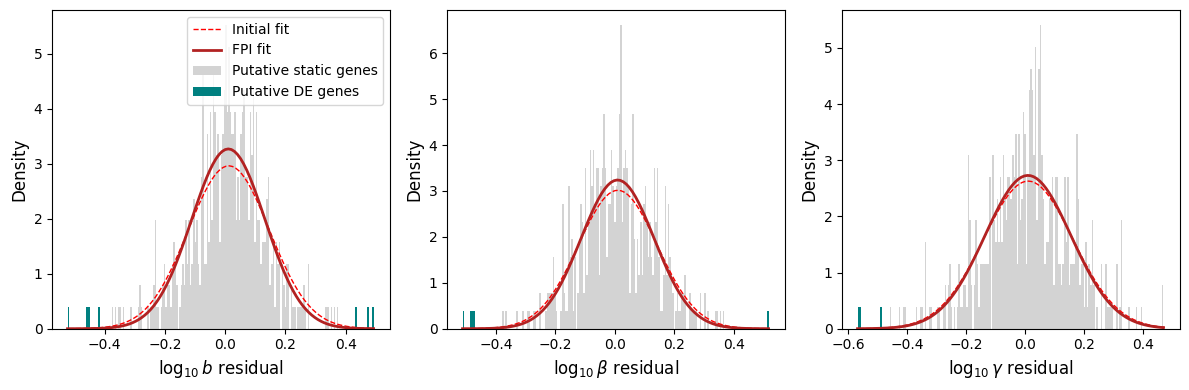

In [ ]:
#Get all DE-theta genes and the corresponding params
gene_names = sr_arr[0].gene_names
all_de_theta = make_fcs_srs(sr_arr[0],sr_arr[1],sd_arr[0],sd_arr[1],gene_names,gf_rej=True,thrpars=1.5,thrmean=0.1,correct_off=True)
all_de_theta.head()

#Can save this output to a csv
all_de_theta.to_csv('day0vs3_detheta_res.csv',index=None)

In [ ]:
all_de_theta.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,deTheta_outlier,log2FC,gene,cluster_pair,deTheta_FC,deTheta_noDeMuS,param
0,False,-0.253164,RAB3GAP2,"[1, 2]",False,False,b
1,False,0.270444,NOTCH2,"[1, 2]",False,False,b
2,False,-0.199124,FNBP1L,"[1, 2]",False,False,b
3,False,0.103254,SLC25A24,"[1, 2]",False,False,b
4,False,0.103399,ARID4B,"[1, 2]",False,False,b


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


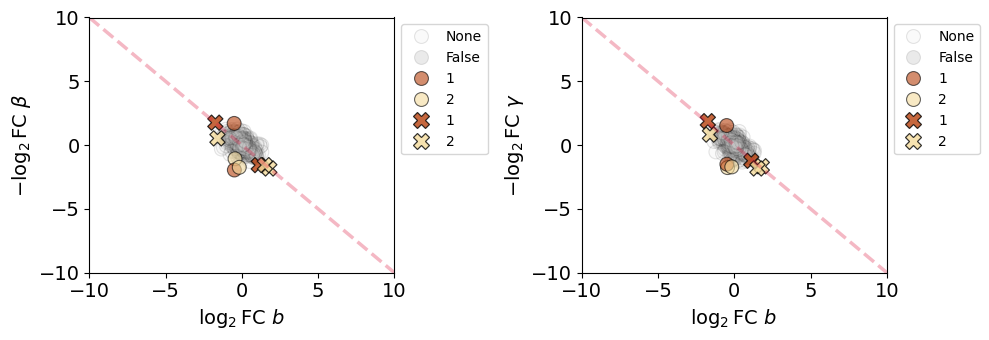

In [ ]:
#Assign DE genes as a marker to first or second results object (Day 0 or 3 marker)
out_marks = get_gene_DE(all_de_theta)

ctrl_palette = {1:'#b7410e',2:'#f4db9d','None':'lightgrey'} #1 - Day 0, 2 - Day 3

#Example code to plot gene names
# names_plot = ['ITGA6','NEXN','ACSS2']
# mark_plot = [2,'None',1,]
# xpos = [-8,3,1,]
# ypos = [-4.5,1.5,7]
# arrow = [True,True,True,]


plot_de(out_marks,
# xpos = [-8,3,1,]
        names_plot=[],mark_plot=[],xpos=[],ypos=[],arrow=[],
        assign_colors=ctrl_palette,
        figsize=(10,3.5),fname='Day0_vsDay3.pdf')

